### Potato Disease Prediction

##### The data used in this prediction model was obtained from Kaggle website. Here is the [link](https://www.kaggle.com/arjuntejaswi/plant-village).

In [1]:
# import relevant libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/gdrive/MyDrive/PlantVillage",
shuffle=True,
image_size =(IMAGE_SIZE, IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

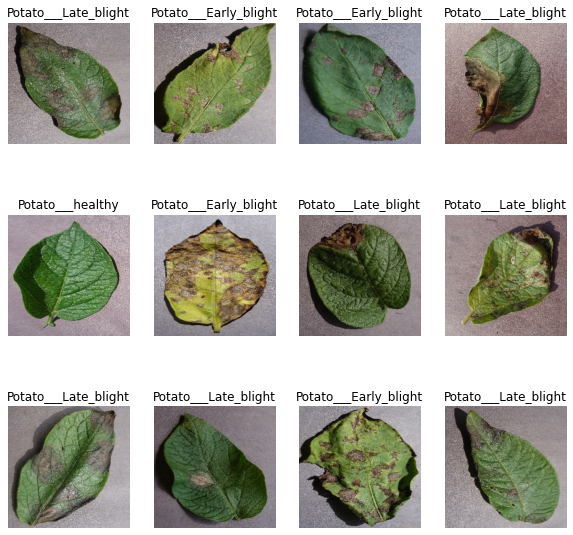

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
# Put all of the above procedures into a python function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
                                          layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                          layers.experimental.preprocessing.Rescaling(1.0/255)
                                          ])

In [22]:
data_augmentation = tf.keras.Sequential([
                                         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2),
                                         ])

### Build and train a Model using Convolutional Neural Network

In [23]:
# Create input shape
# Input shape should have a batch size, image size and channels in that order
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define number of classes
n_classes = 3

# Build a model
model = models.Sequential([
                           resize_and_rescale,
                           data_augmentation,
                           layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation="relu"),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation="relu"),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation="relu"),
                           layers.MaxPooling2D((2,2)),
                           layers.Flatten(),
                           layers.Dense(64, activation="relu"),
                           layers.Dense(n_classes, activation="softmax"), # softmax will normalize probbility of your classes
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, # prints lots of output
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 264s 218ms/step - loss: 0.9243 - accuracy: 0.4861 - val_loss: 0.8432 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 7s 123ms/step - loss: 0.7193 - accuracy: 0.7025 - val_loss: 0.8546 - val_accuracy: 0.7135
Epoch 3/50
54/54 [==============================] - 7s 121ms/step - loss: 0.5673 - accuracy: 0.7598 - val_loss: 0.3655 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 7s 121ms/step - loss: 0.3985 - accuracy: 0.8299 - val_loss: 0.3223 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 7s 121ms/step - loss: 0.3716 - accuracy: 0.8490 - val_loss: 0.3199 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 7s 121ms/step - loss: 0.2801 - accuracy: 0.8883 - val_loss: 0.2635 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 7s 121ms/step - loss: 0.2518 - accuracy: 0.9034 - val_loss: 0.3420 - val_accuracy: 0.8594
Epoc

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 47ms/step - loss: 0.0104 - accuracy: 0.9961


In [28]:
scores

[0.01043812558054924, 0.99609375]

In [29]:
history

Check on google keras.callbacks history for more information

In [30]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.4861111044883728,
 0.7025462985038757,
 0.7598379850387573,
 0.8298611044883728,
 0.8489583134651184,
 0.8883101940155029,
 0.9033564925193787,
 0.9189814925193787,
 0.9270833134651184,
 0.9357638955116272,
 0.9380787014961243,
 0.9259259104728699,
 0.9461805820465088,
 0.9542824029922485,
 0.9612268805503845,
 0.9629629850387573,
 0.9508101940155029,
 0.9473379850387573,
 0.9554398059844971,
 0.9548611044883728,
 0.9635416865348816,
 0.9733796119689941,
 0.9780092835426331,
 0.9849537014961243,
 0.9820601940155029,
 0.9803240895271301,
 0.96875,
 0.9861111044883728,
 0.9762731194496155,
 0.9890046119689941,
 0.9762731194496155,
 0.9797453880310059,
 0.9890046119689941,
 0.9832175970077515,
 0.9832175970077515,
 0.9890046119689941,
 0.9947916865348816,
 0.9930555820465088,
 0.9913194179534912,
 0.9745370149612427,
 0.9704861044883728,
 0.9855324029922485,
 0.9849537014961243,
 0.9907407164573669,
 0.9803240895271301,
 0.9947916865348816,
 0.9924768805503845,
 0.9953703880310059,
 0.

In [33]:
# plot the history accuracy in a matplotlib graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

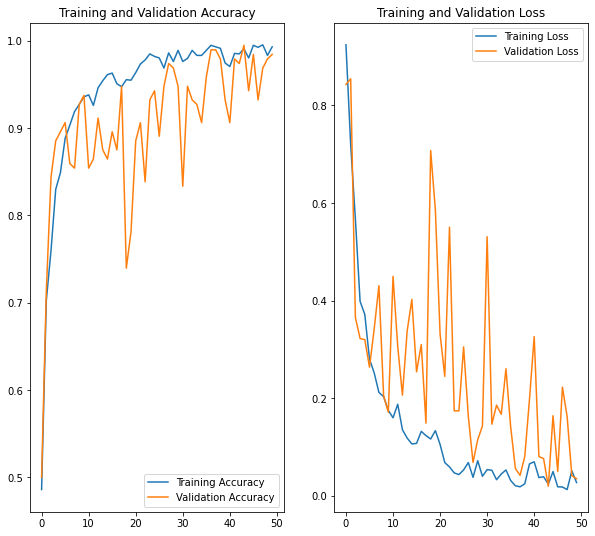

In [46]:
# plot the Training and Validation Accuracy
plt.figure(figsize=(10,9))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy');

# plot the loss chart
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss');

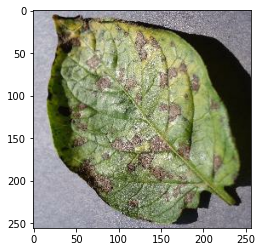

In [49]:
# make a prediction with the test dataset
for images_batch, labels_batch in test_ds.take(1):

  plt.imshow(images_batch[0].numpy().astype('uint8')) # print(images_batch[0]) returns tensors. Use .numpy() to change to numpy

First image to predict
Actual label: Potato___Late_blight
Predicted label Potato___Late_blight


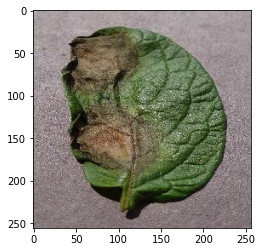

In [62]:
# Import numpy
import numpy as np

# make a prediction with the test dataset
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label:", class_names[first_label])

  # Create a predicted image
  batch_prediction = model.predict(image_batch) # Prediction for 32 labels
  print(f"Predicted label {class_names[np.argmax(batch_prediction[0])]}")
        

Softmax gives probability which are 3 ([8.9711725e-04, 9.9910259e-01, 3.5708547e-07]) in this case as shown above because our model was a three dimensional matrix. We will use the highest class probability by calling the np.argmax(). It will give the index with the highest probability.

In [53]:
# locate the index wuth the highest prediction class probality
np.argmax([[8.9711725e-04, 9.9910259e-01, 3.5708547e-07]])

1

In [63]:
# build a fuction that takes model and image as input 
# and returns predicted class and confidence
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # convert an image into image array
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array) # call predict function to predict the image array

  predicted_class = class_names[np.argmax(predictions[0])] # get the best predicted class
  confidence = round(100 * (np.max(predictions[0])), 2) # create a confidence for the predictions
  return predicted_class, confidence # Confidence means accuracy of the prediction is 100%

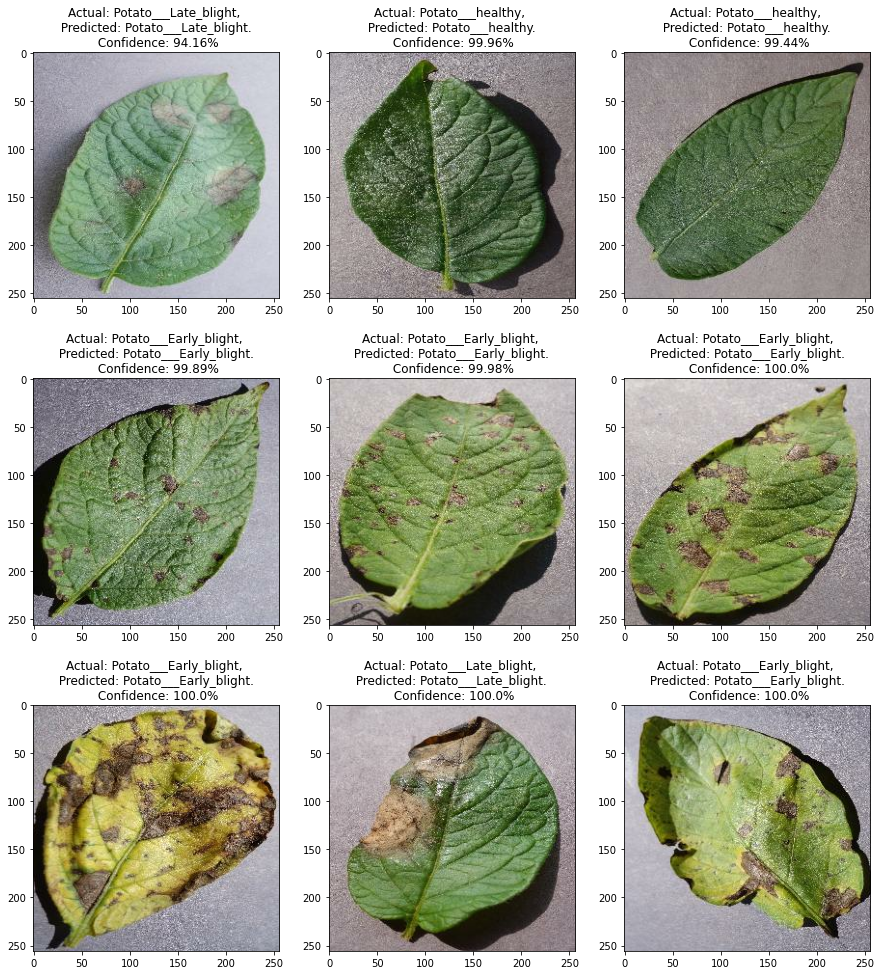

In [76]:
# predict 9 images using the function above
plt.figure(figsize=(15,17)) # Increase the figure size
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1) # Use a subplot function to display all the nine predicted images
    plt.imshow(images[i].numpy().astype("uint8"))
    
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

    plt.axis = "off" # Remove the axis values

In [79]:
# import os
# modelversion=max([int(i) for i in os.listdir("../models") + [0]])
# model.save(f"../models{model_version}")

In [77]:
# Create a folder in your local machine and save your model using the code below
model_version=1
model.save(f"../models{model_version}")

INFO:tensorflow:Assets written to: ../models1/assets
